# 🔁 STEP 1: Install Dependencies & Setup Kaggle API

In [1]:
# Install opendatasets to download from Kaggle
!pip install -q opendatasets

# Upload your kaggle.json file (API Key)
from google.colab import files
files.upload()  # Upload kaggle.json

# Move kaggle.json to the correct directory
import os
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


# 📥 STEP 2: Download Dataset from Kaggle

In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents")

Skipping, found downloaded files in "./us-accidents" (use force=True to force download)


# 📊 STEP 3: Load Dataset in Chunks (Efficient for large dataset)

In [3]:
import pandas as pd

file_path = "us-accidents/US_Accidents_March23.csv"
chunksize = 500_000

df_list = []
for chunk in pd.read_csv(file_path, chunksize=chunksize, low_memory=False):
    # ✅ Explicitly convert to datetime
    chunk['Start_Time'] = pd.to_datetime(chunk['Start_Time'], errors='coerce')

    # ✅ Filter after ensuring datetime
    filtered_chunk = chunk[chunk['Start_Time'].dt.year >= 2020]

    df_list.append(filtered_chunk)

df = pd.concat(df_list, ignore_index=True)
print(f"✅ Loaded {df.shape[0]:,} rows.")


✅ Loaded 4,009,389 rows.


# 🧹 STEP 4: Data Cleaning & Feature Engineering

In [4]:
# Drop high-missing or less useful columns
df.drop(columns=[
    'Number', 'End_Lat', 'End_Lng', 'Wind_Chill(F)',
    'Precipitation(in)', 'Turning_Loop'
], inplace=True, errors='ignore')

# Convert remaining datetime
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Feature Engineering
df['Hour'] = df['Start_Time'].dt.hour
df['DayOfWeek'] = df['Start_Time'].dt.dayofweek
df['Month'] = df['Start_Time'].dt.month
df['Year'] = df['Start_Time'].dt.year
df['Is_Weekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
df['Day/Night'] = df['Sunrise_Sunset'].fillna('Day')

# 📈 STEP 5: Exploratory Data Analysis (EDA)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# 🛣️ STEP 6: Infrastructure Features vs Severity

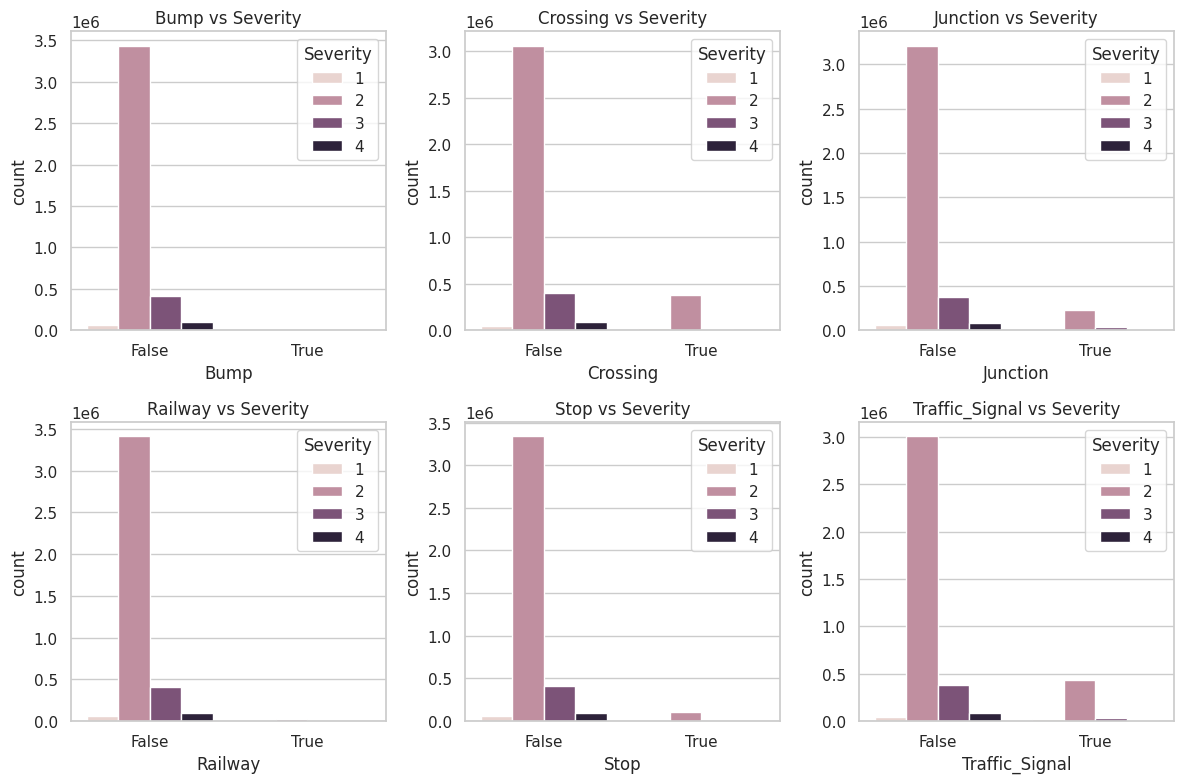

In [6]:
infra_cols = ['Bump', 'Crossing', 'Junction', 'Railway', 'Stop', 'Traffic_Signal']
plt.figure(figsize=(12, 8))
for i, col in enumerate(infra_cols, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=col, hue='Severity', data=df)
    plt.title(f'{col} vs Severity')
plt.tight_layout()
plt.show()

## Top 10 cities

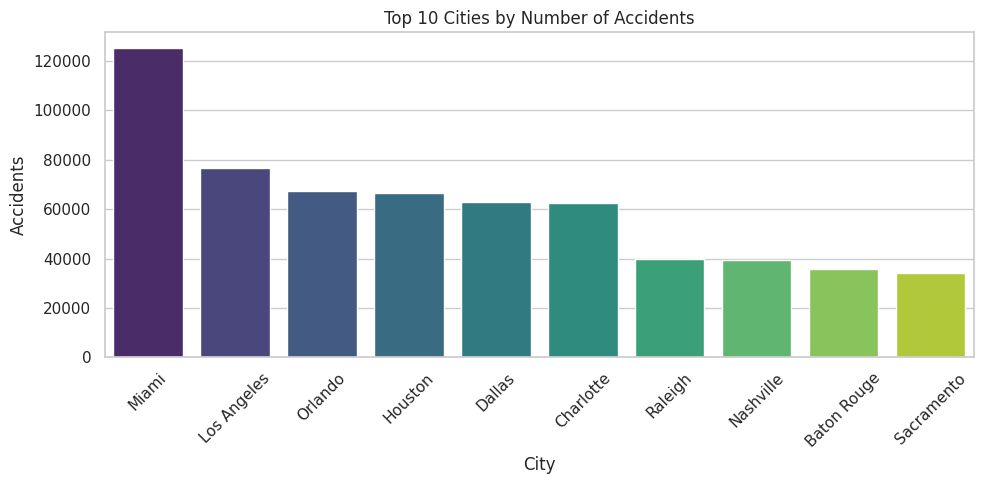

In [7]:
top_cities = df['City'].value_counts().nlargest(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_cities.index, y=top_cities.values, palette="viridis")
plt.title('Top 10 Cities by Number of Accidents')
plt.xticks(rotation=45)
plt.ylabel('Accidents')
plt.tight_layout()
plt.show()

## Accidents by Hour

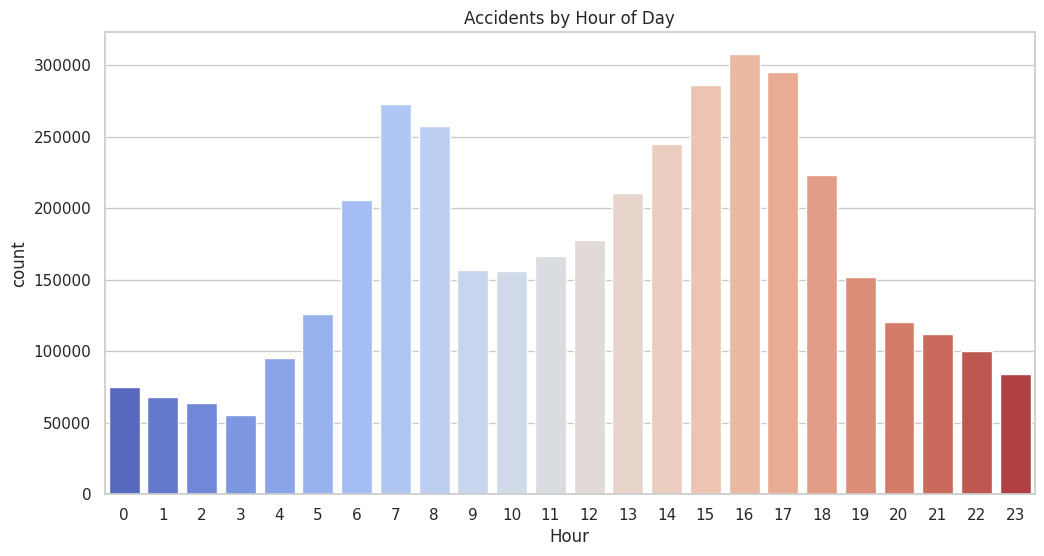

In [8]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Hour', data=df, palette='coolwarm')
plt.title('Accidents by Hour of Day')
plt.show()

## Accidents by Day of Week

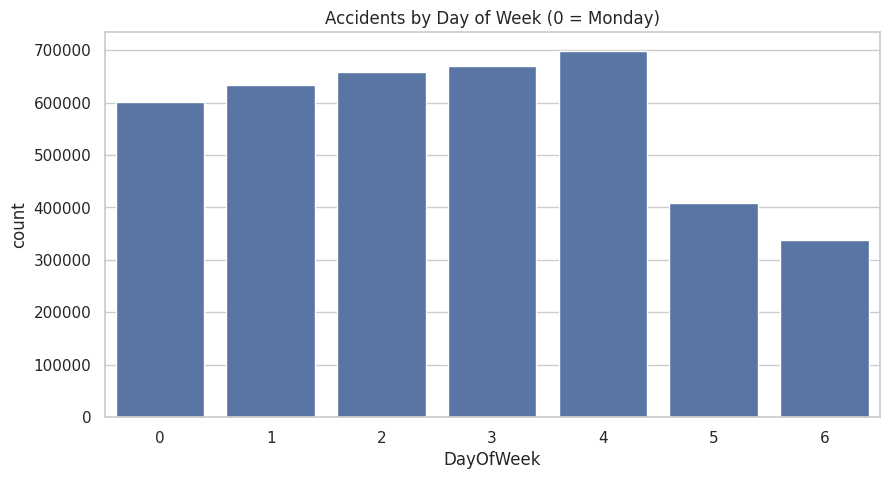

In [9]:
plt.figure(figsize=(10, 5))
sns.countplot(x='DayOfWeek', data=df)
plt.title("Accidents by Day of Week (0 = Monday)")
plt.show()

## Severity vs Temperature

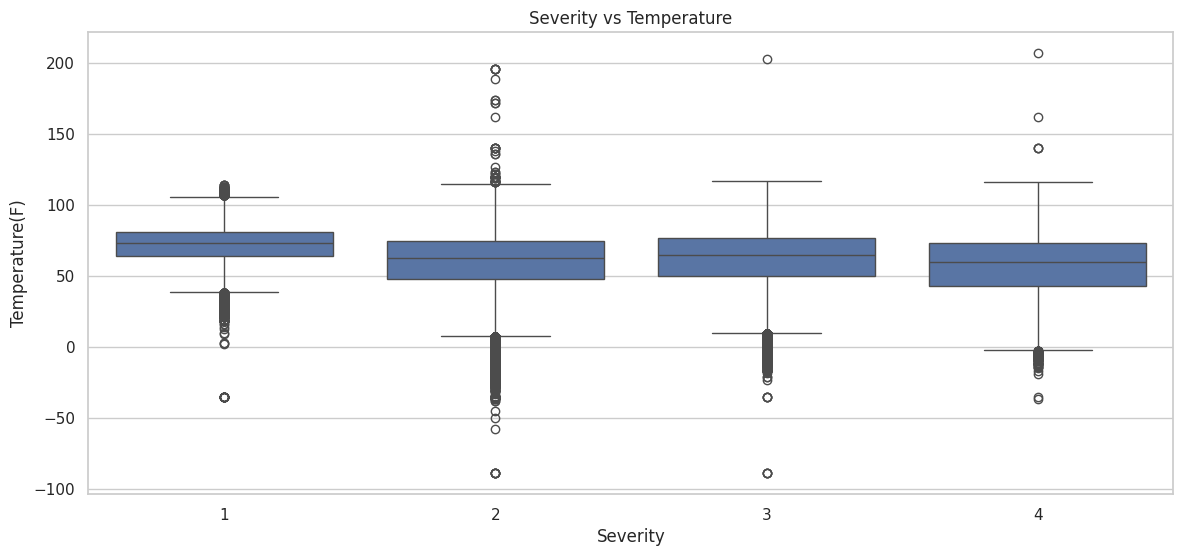

In [10]:
plt.figure(figsize=(14,6))
sns.boxplot(x='Severity', y='Temperature(F)', data=df)
plt.title("Severity vs Temperature")
plt.show()

## Severity vs Visibility

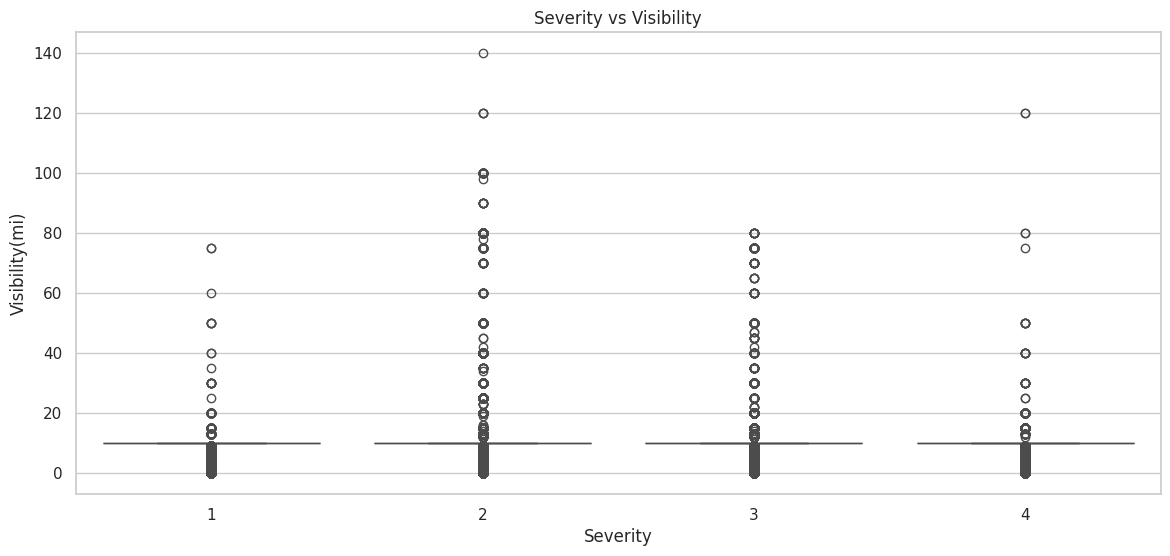

In [11]:
plt.figure(figsize=(14,6))
sns.boxplot(x='Severity', y='Visibility(mi)', data=df)
plt.title("Severity vs Visibility")
plt.show()

# 🌍 STEP 7: Heatmap of Accident Hotspots (Los Angeles)

In [12]:
import folium
from folium.plugins import HeatMap
import os

# Ensure output folder exists
os.makedirs("heatmaps", exist_ok=True)

# Top 10 cities by accident count
top_10_cities = df['City'].value_counts().head(10).index

for city in top_10_cities:
    city_df = df[df['City'] == city].dropna(subset=['Start_Lat', 'Start_Lng'])

    if city_df.empty:
        print(f"⚠️ Skipped {city}: no valid coordinates.")
        continue

    # Center map at the average location
    lat_center = city_df['Start_Lat'].mean()
    lng_center = city_df['Start_Lng'].mean()

    city_map = folium.Map(location=[lat_center, lng_center], zoom_start=10)
    HeatMap(data=city_df[['Start_Lat', 'Start_Lng']].values, radius=8).add_to(city_map)

    filename = f"heatmaps/{city.replace(' ', '_')}_heatmap.html"
    city_map.save(filename)
    print(f"✅ Saved heatmap for {city}: {filename}")

✅ Saved heatmap for Miami: heatmaps/Miami_heatmap.html
✅ Saved heatmap for Los Angeles: heatmaps/Los_Angeles_heatmap.html
✅ Saved heatmap for Orlando: heatmaps/Orlando_heatmap.html
✅ Saved heatmap for Houston: heatmaps/Houston_heatmap.html
✅ Saved heatmap for Dallas: heatmaps/Dallas_heatmap.html
✅ Saved heatmap for Charlotte: heatmaps/Charlotte_heatmap.html
✅ Saved heatmap for Raleigh: heatmaps/Raleigh_heatmap.html
✅ Saved heatmap for Nashville: heatmaps/Nashville_heatmap.html
✅ Saved heatmap for Baton Rouge: heatmaps/Baton_Rouge_heatmap.html
✅ Saved heatmap for Sacramento: heatmaps/Sacramento_heatmap.html


# 📊 STEP 8: Advanced Insights

## Severity distribution

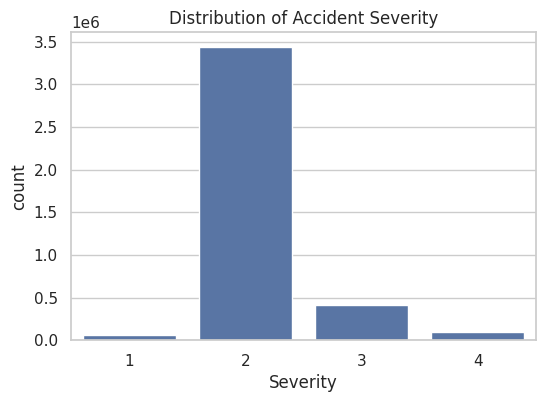

In [13]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Severity', data=df)
plt.title("Distribution of Accident Severity")
plt.show()

## Severity by Weather Condition

<Figure size 1200x600 with 0 Axes>

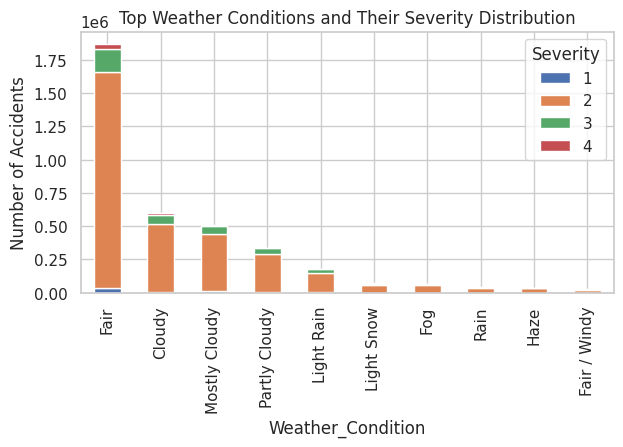

In [14]:
severity_weather = df.groupby(['Severity', 'Weather_Condition'])['ID'].count().unstack().fillna(0)
top_weather = severity_weather.sum().sort_values(ascending=False).head(10).index

plt.figure(figsize=(12, 6))
severity_weather[top_weather].T.plot(kind='bar', stacked=True)
plt.title("Top Weather Conditions and Their Severity Distribution")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()

## Correlation Heatmap

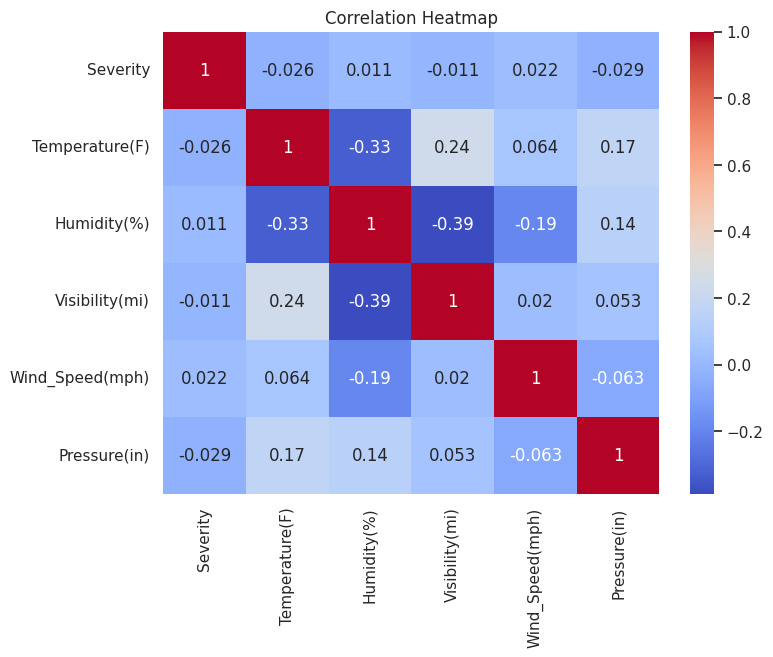

In [15]:
corr = df[['Severity', 'Temperature(F)', 'Humidity(%)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Pressure(in)']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# 💾 STEP 9: Save Cleaned Dataset (Optional)

In [16]:
df.to_csv("us_accidents_filtered_cleaned.csv", index=False)
print("✅ Saved cleaned data as 'us_accidents_filtered_cleaned.csv'")

✅ Saved cleaned data as 'us_accidents_filtered_cleaned.csv'
